In [ ]:
# https://towardsdatascience.com/multi-class-text-classification-with-lstm-1590bee1bd17

!pip install tensorflow-gpu
!pip install nltk
!pip install keras
!pip install pydot
!pip install wordcloud
!pip install chart-studio

In [ ]:
import numpy as np
import nltk
import re
import pydot
from wordcloud import WordCloud, ImageColorGenerator
#import tensorflow as tf
#from tensorflow import keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from keras.utils.np_utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.layers import Dropout
import pandas as pd
import seaborn as sns
import plotly.graph_objects as go
import chart_studio.plotly as py
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from pandas.plotting import register_matplotlib_converters
from nltk.corpus import stopwords
from nltk import word_tokenize
nltk.download('stopwords')
STOPWORDS = set(stopwords.words('english'))

#import numpy as np 
#import pandas as pd
#import matplotlib.pyplot as plt
#import seaborn as sns
#from keras.preprocessing.text import Tokenizer
#from keras.preprocessing.sequence import pad_sequences
#from keras.models import Sequential
#from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
#from sklearn.model_selection import train_test_split
#from keras.utils.np_utils import to_categorical
#from keras.callbacks import EarlyStopping
#from keras.layers import Dropout
#import re
#from nltk.corpus import stopwords
#from nltk import word_tokenize
#STOPWORDS = set(stopwords.words('english'))
#from bs4 import BeautifulSoup
#import plotly.graph_objs as go
#import plotly.plotly as py
#import cufflinks
#from IPython.core.interactiveshell import InteractiveShell
#import plotly.figure_factory as ff
#InteractiveShell.ast_node_interactivity = 'all'
#from plotly.offline import iplot
#cufflinks.go_offline()
#cufflinks.set_config_file(world_readable=True, theme='pearl')

In [ ]:
df = pd.read_csv('coded_sub_section.csv',header=0)


In [ ]:
df.head()

In [ ]:
df.shape

In [ ]:
df.Cond_Category.value_counts()

In [ ]:
df.Determination_Year.value_counts()

In [ ]:
df = df.drop(['Textfile','Sub_Header','Cond_Category','Determination_Year'],axis=1)

In [ ]:
df['Stars'] = 0
df.head()

In [ ]:
for i in range(len(df)):
    if df.iloc[i,1] < .2:
        df.iloc[i,2] = 1
    elif df.iloc[i,1] < .4:
        df.iloc[i,2] = 2
    elif df.iloc[i,1] < .6:
        df.iloc[i,2] = 3
    elif df.iloc[i,1] < .8:
        df.iloc[i,2] = 4
    elif df.iloc[i,1] > .8:
        df.iloc[i,2] = 5  
        
df = df.drop(['EScore'],axis=1)

In [ ]:
print(STOPWORDS)

# Text Processing 

- Convert all text to lower case.
- Replace REPLACE_BY_SPACE_RE symbols by space in text.
- Remove symbols that are in BAD_SYMBOLS_RE from text.
- Remove stop words.
- Remove digits in text.
- Remove single letters


In [55]:
df = df.reset_index(drop=True)
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
SINGLE_LETTERS_RE = re.compile('\s+[a-zA-Z]\s+')
STOPWORDS = set(stopwords.words('english'))
STOPWORDS.remove('should')
#STOPWORDS.add('applicant')
#STOPWORDS.add('proponent')
STOPWORDS.add('groundwater')
STOPWORDS.add('water')
STOPWORDS.add('environment')
STOPWORDS.add('act')

def clean_text(text):
    """
        text: a string
        
        return: modified initial string
    """
    text = text.lower() # lowercase text
    text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text. substitute the matched string in REPLACE_BY_SPACE_RE with space.
    text = BAD_SYMBOLS_RE.sub('', text) # remove symbols which are in BAD_SYMBOLS_RE from text. substitute the matched string in BAD_SYMBOLS_RE with nothing. 
#    text = SINGLE_LETTERS_RE.sub('', text) # remove single letters
#    text = text.replace('x', '')
#    text = re.sub(r'\W+', '', text)
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) # remove stopwords from text
    return text

df['Sub_Section'] = df['Sub_Section'].apply(clean_text)
df['Sub_Section'] = df['Sub_Section'].str.replace('\d+', '')

In [56]:
print(df['Sub_Section'][600])

proponent shall commission suitably qualified independent expert whose appointment approved directorgeneral carry detailed survey geotechnical geomorphic ecological baseline condition xstrata mt owen bettys creek diversions prior carrying second workings creek diversions within months completing second workings creek diversions b provide copy surveys department within month completion survey


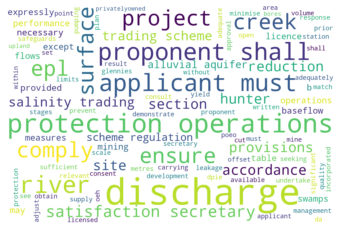

In [57]:
wordcloud = WordCloud(max_words=100, stopwords=STOPWORDS, background_color="white",width=1200,height=800).generate(str(df['Sub_Section']))
# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear', )
plt.axis("off")
plt.show()

# Save the image in the img folder:
wordcloud.to_file("wordcloud.png")

# Tokenising

- Vectorize text into either a sequence of integers or into a vector.
- Limit the data set to the top 125,0000 words.
- Set the max number of words for each sub_section at 500.
- Truncate and pad the subsections with zeros


In [58]:
# The maximum number of words to be used. (most frequent)
MAX_NB_WORDS = 3000
# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 500
# This is fixed.
EMBEDDING_DIM = 100
tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(df['Sub_Section'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

X = tokenizer.texts_to_sequences(df['Sub_Section'].values)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X.shape)


Y = pd.get_dummies(df['Stars']).values
print('Shape of label tensor:', Y.shape)

Found 1907 unique tokens.
Shape of data tensor: (822, 500)
Shape of label tensor: (822, 5)


In [59]:
print((df['Stars']).values)

[5 5 5 5 4 5 2 3 5 5 5 5 5 4 4 2 5 5 2 5 2 5 5 5 2 3 4 5 1 5 5 5 5 5 4 5 1
 2 5 3 2 5 5 5 1 5 5 5 1 2 2 2 5 5 2 2 5 2 3 5 3 5 5 2 5 2 2 5 1 5 1 1 5 5
 1 5 2 5 2 5 5 2 5 2 5 2 5 2 2 5 4 2 2 2 3 5 5 2 5 5 5 1 1 5 5 5 2 5 5 2 5
 5 2 5 5 1 3 5 5 5 5 1 1 1 5 1 1 5 3 1 5 5 5 5 5 5 5 5 4 2 5 1 3 5 2 2 5 1
 4 5 5 1 5 1 5 5 2 5 5 5 5 1 5 1 5 2 5 5 5 2 2 5 5 5 5 1 5 1 3 5 5 5 5 3 1
 3 1 3 1 1 2 1 3 1 3 1 1 3 1 3 1 1 1 1 3 1 1 1 1 1 1 3 1 1 1 1 1 1 1 1 1 1
 1 3 1 3 1 3 1 2 1 1 1 1 1 1 1 3 1 1 1 1 1 1 1 1 3 1 3 1 1 3 1 1 1 1 1 1 3
 1 1 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1 3 1 1 1 1 5 5 4 4 4 1 1 1 1 4 5 4 4 1 1
 1 4 5 4 4 4 3 1 1 1 1 4 5 4 4 4 1 4 4 5 4 4 2 1 1 1 1 4 4 2 1 1 1 1 4 5 4
 4 1 1 1 1 1 1 1 1 1 5 1 1 4 4 5 4 4 2 1 1 1 1 1 1 1 1 1 1 4 4 5 4 4 2 1 4
 4 4 3 3 4 5 4 2 1 1 1 1 1 1 1 1 1 4 4 4 1 1 1 1 1 1 3 1 4 4 2 4 1 1 1 1 1
 1 1 4 4 2 4 1 1 4 4 4 1 1 1 3 1 1 1 1 1 1 1 1 4 4 5 4 4 2 1 4 4 4 1 4 5 2
 4 4 1 1 2 1 5 5 4 4 4 1 5 1 3 3 1 1 1 1 1 1 1 1 1 1 4 5 2 4 4 1 1 1 1 1 1
 1 4 5 4 4 4 1 1 3 1 3 1 

In [60]:
df['Stars'].describe()

count    822.000000
mean       2.447689
std        1.551884
min        1.000000
25%        1.000000
50%        2.000000
75%        4.000000
max        5.000000
Name: Stars, dtype: float64

In [61]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.10, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(739, 500) (739, 5)
(83, 500) (83, 5)


In [62]:
#sns.lineplot(x=train.index, y="Stars", data=train);
#sns.lineplot(x=test.index, y="Stars", data=test);

In [63]:
model = Sequential()
model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(5, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 500, 100)          300000    
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 500, 100)          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 505       
Total params: 380,905
Trainable params: 380,905
Non-trainable params: 0
_________________________________________________________________
None


In [64]:
# from keras.utils import plot_model
# plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [66]:
epochs = 20
batch_size = 64

history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size,validation_split=0.1,callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])

Epoch 1/20
11/11 [==============================] - 6s 584ms/step - loss: 0.7650 - accuracy: 0.8060 - val_loss: 1.5948 - val_accuracy: 0.4054
Epoch 2/20
11/11 [==============================] - 6s 580ms/step - loss: 0.8185 - accuracy: 0.7143 - val_loss: 0.5996 - val_accuracy: 0.8919
Epoch 3/20
11/11 [==============================] - 6s 581ms/step - loss: 0.2788 - accuracy: 0.9414 - val_loss: 0.2023 - val_accuracy: 0.9730
Epoch 4/20
11/11 [==============================] - 6s 584ms/step - loss: 0.1631 - accuracy: 0.9609 - val_loss: 0.2043 - val_accuracy: 0.9595
Epoch 5/20
11/11 [==============================] - 6s 590ms/step - loss: 0.0958 - accuracy: 0.9744 - val_loss: 0.1819 - val_accuracy: 0.9595
Epoch 6/20
11/11 [==============================] - 6s 582ms/step - loss: 0.0795 - accuracy: 0.9805 - val_loss: 0.1463 - val_accuracy: 0.9730
Epoch 7/20
11/11 [==============================] - 6s 584ms/step - loss: 0.0875 - accuracy: 0.9684 - val_loss: 0.1578 - val_accuracy: 0.9865
Epoch 

In [67]:
accr = model.evaluate(X_test,Y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

3/3 [==============================] - 0s 70ms/step - loss: 0.3169 - accuracy: 0.9036
Test set
  Loss: 0.317
  Accuracy: 0.904


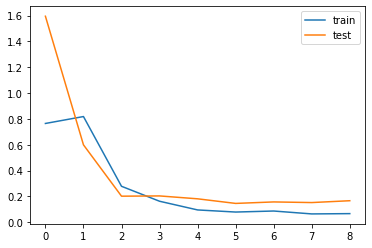

In [68]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend();

In [69]:
print(history.history)

{'loss': [0.7650145292282104, 0.8185257911682129, 0.2788121700286865, 0.1630754917860031, 0.09582347422838211, 0.07951311767101288, 0.08746708929538727, 0.06502877175807953, 0.06726668775081635], 'accuracy': [0.8060150146484375, 0.7142857313156128, 0.9413533806800842, 0.9609022736549377, 0.9744361042976379, 0.9804511070251465, 0.9684210419654846, 0.9804511070251465, 0.9789473414421082], 'val_loss': [1.5947622060775757, 0.5996482372283936, 0.202256977558136, 0.20426034927368164, 0.18187344074249268, 0.14628508687019348, 0.15779945254325867, 0.15288950502872467, 0.16714085638523102], 'val_accuracy': [0.4054054021835327, 0.8918918967247009, 0.9729729890823364, 0.9594594836235046, 0.9594594836235046, 0.9729729890823364, 0.9864864945411682, 0.9864864945411682, 0.9729729890823364]}


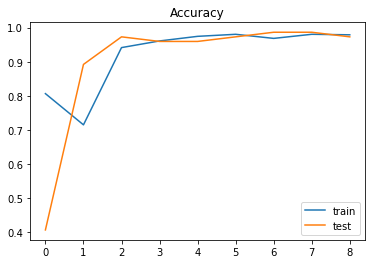

In [70]:
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.show();

In [92]:
new_sub_header = []
new_sub_header = ['The rail spur line rail spur bridges and any upgrade to the haul road must be designed and constructed to \
minimise impacts on flooding. Prior to construction of the rail spur line or any upgrades to the haul road \
the Proponent shall undertake a flood assessment of the detailed design to confirm there would be minimal \
impacts as predicted in the EA. \
 ']

df_new = pd.DataFrame(new_sub_header)
df_new[0] = df_new[0].apply(clean_text)
df_new[0] = df_new[0].str.replace('\d+', '')

pd.set_option('display.max_colwidth', None)
print(str(df_new[0]))

seq = tokenizer.texts_to_sequences(df_new[0].values)
padded = pad_sequences(seq, maxlen=MAX_SEQUENCE_LENGTH)
pred = model.predict(padded)
labels = ['1', '2', '3', '4', '5']
print(pred, labels[np.argmax(pred)])
#print(pred,[np.argmax(pred)])                 

0    rail spur line rail spur bridges upgrade haul road must designed constructed minimise impacts flooding prior construction rail spur line upgrades haul road proponent shall undertake flood assessment detailed design confirm would minimal impacts predicted ea
Name: 0, dtype: object
[[0.00507444 0.90311176 0.05652528 0.00623532 0.02905325]] 2


In [53]:
from plotly.offline import plot
from chart_studio.plotly import plot, iplot
from plotly.subplots import make_subplots

fig = go.Figure(go.Indicator(
    domain = {'x': [0, 1], 'y': [0, 1]},
    value = 5,
    mode = "gauge+number+delta",
    title = {'text': "Enforceability Score"},
    delta = {'reference': 3},
    gauge = {'axis': {'range': [None, 5]},
             'steps' : [
                 {'range': [0, 2], 'color': "lightgray"},
                 {'range': [2, 4], 'color': "gray"},
                 {'range': [4, 5], 'color': "green"}],
             'threshold' : {'line': {'color': "red", 'width': 4}, 'thickness': 0.75, 'value': 4}}))

plotly.offline.iplot(fig)
#fig.show()

NameError: name 'plotly' is not defined

In [54]:
import chart_studio.plotly as py
from plotly.offline import plot, iplot
trace0 = go.Scatter(
    x=[1, 2, 3, 4],
    y=[10, 15, 13, 17]
)
trace1 = go.Scatter(
    x=[1, 2, 3, 4],
    y=[16, 5, 11, 9]
)
data = [trace0, trace1]

py.iplot(data, filename = 'basic-line')

PlotlyRequestError: Authentication credentials were not provided.

In [ ]:
import chart_studio.plotly as py
from plotly.offline import plot
help(py.plot)